# COVID-19 数据分析：健康与社会经济影响

本 notebook 将分析 COVID-19 的健康和社会经济影响，主要研究以下问题：
1. COVID-19 如何影响不同地区的预期寿命
2. 健康影响（病例数、死亡数）与经济影响（GDP 下降、失业率）的对比
3. 低收入国家是否比富裕国家受到更不成比例的影响

## 1. 数据准备与导入

In [82]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import statsmodels.api as sm
from scipy import stats

# 导入自定义工具函数
from covid_analysis_utils import *

# 设置中文字体
setup_chinese_fonts()

# 设置绘图风格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [83]:
# 加载并预处理数据
df = load_and_preprocess_data()
print(f"数据集大小: {df.shape}")
df.head()

数据集大小: (429435, 72)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,5,1,1
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,6,2,1
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,7,2,1
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,8,2,1
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,9,2,1


## 2. 数据清洗与准备

In [84]:
# 数据清洗
df_clean = clean_data(df)

原始数据形状: (429435, 72)
缺失值比例:
weekly_icu_admissions                      97.440125
weekly_icu_admissions_per_million          97.440125
excess_mortality_cumulative_per_million    96.877059
excess_mortality_cumulative_absolute       96.877059
excess_mortality_cumulative                96.877059
                                             ...    
new_deaths_per_million                      4.384133
total_deaths                                4.105627
total_cases                                 4.105627
total_deaths_per_million                    4.105627
total_cases_per_million                     4.105627
Length: 63, dtype: float64

清洗后数据形状: (429435, 72)


In [85]:
# 查看与社会经济相关的列
socio_columns = ['gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index']
print("社会经济相关列:")
for col in socio_columns:
    print(f"- {col}")

# 检查数据的可用性
print("\n数据可用性（非空值百分比）:")
for col in socio_columns:
    non_null_pct = (df_clean[col].notnull().sum() / len(df_clean)) * 100
    print(f"- {col}: {non_null_pct:.2f}%")

社会经济相关列:
- gdp_per_capita
- extreme_poverty
- life_expectancy
- human_development_index

数据可用性（非空值百分比）:
- gdp_per_capita: 76.45%
- extreme_poverty: 49.37%
- life_expectancy: 90.89%
- human_development_index: 74.31%


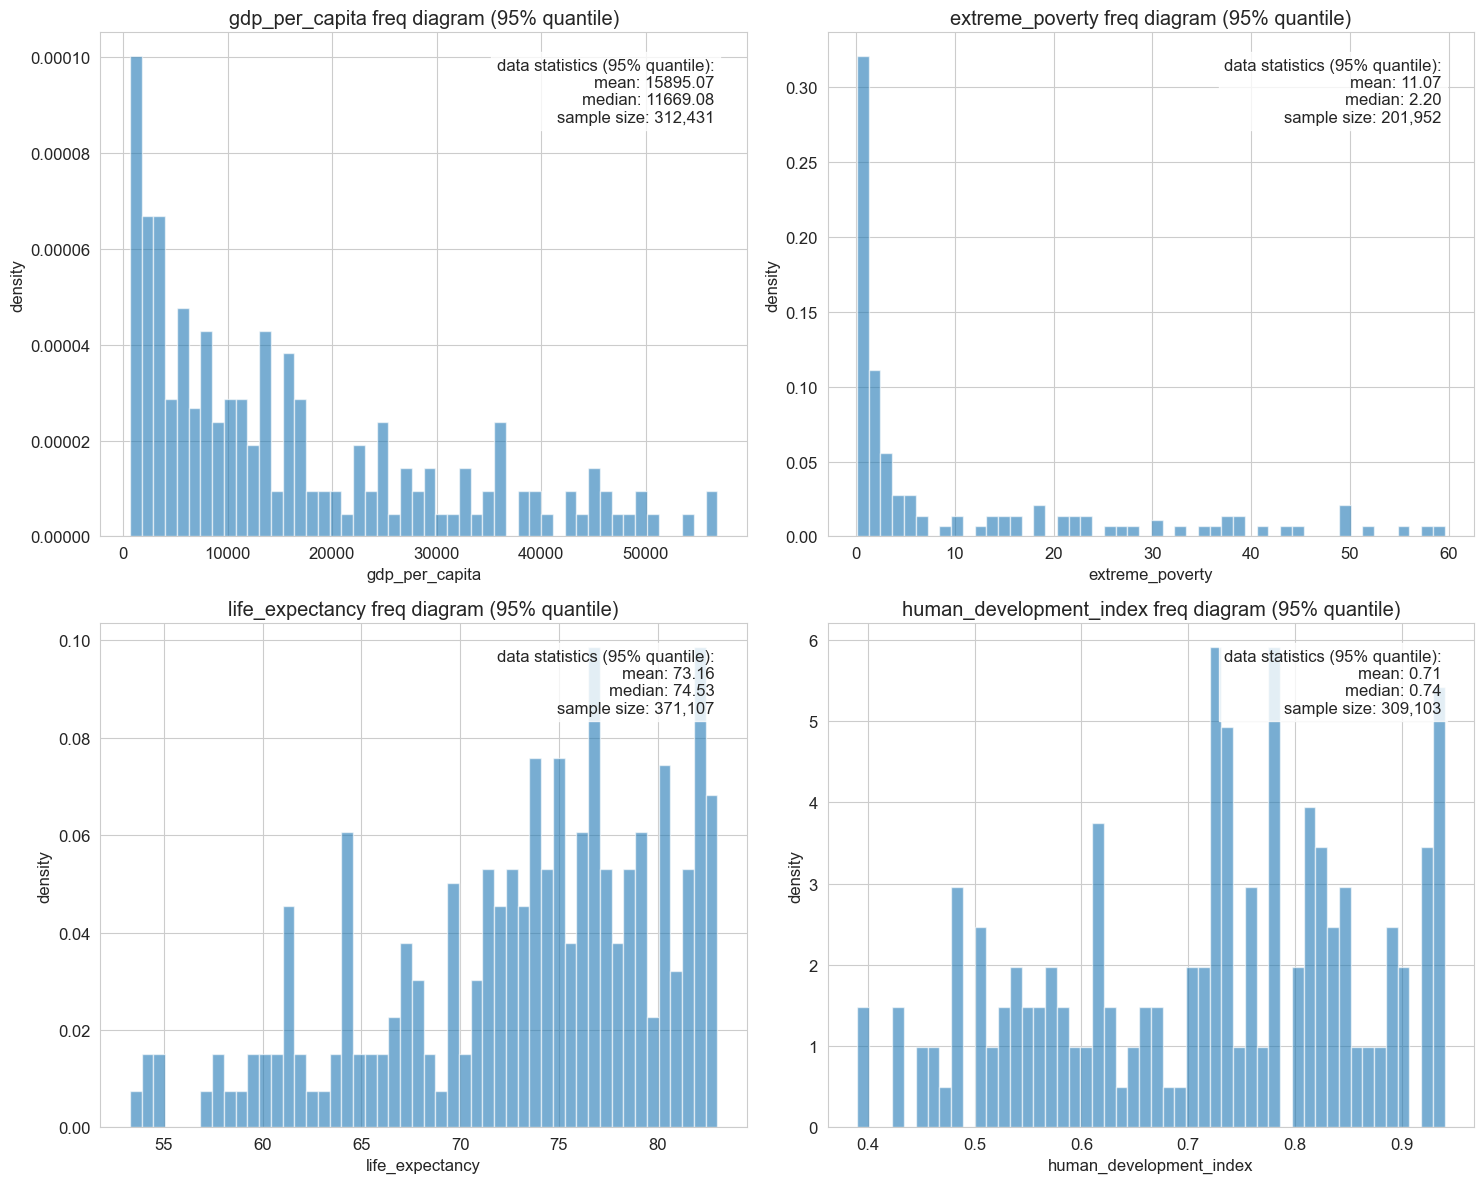

In [86]:
plot_frequency_distribution(
    df_clean, [*socio_columns])



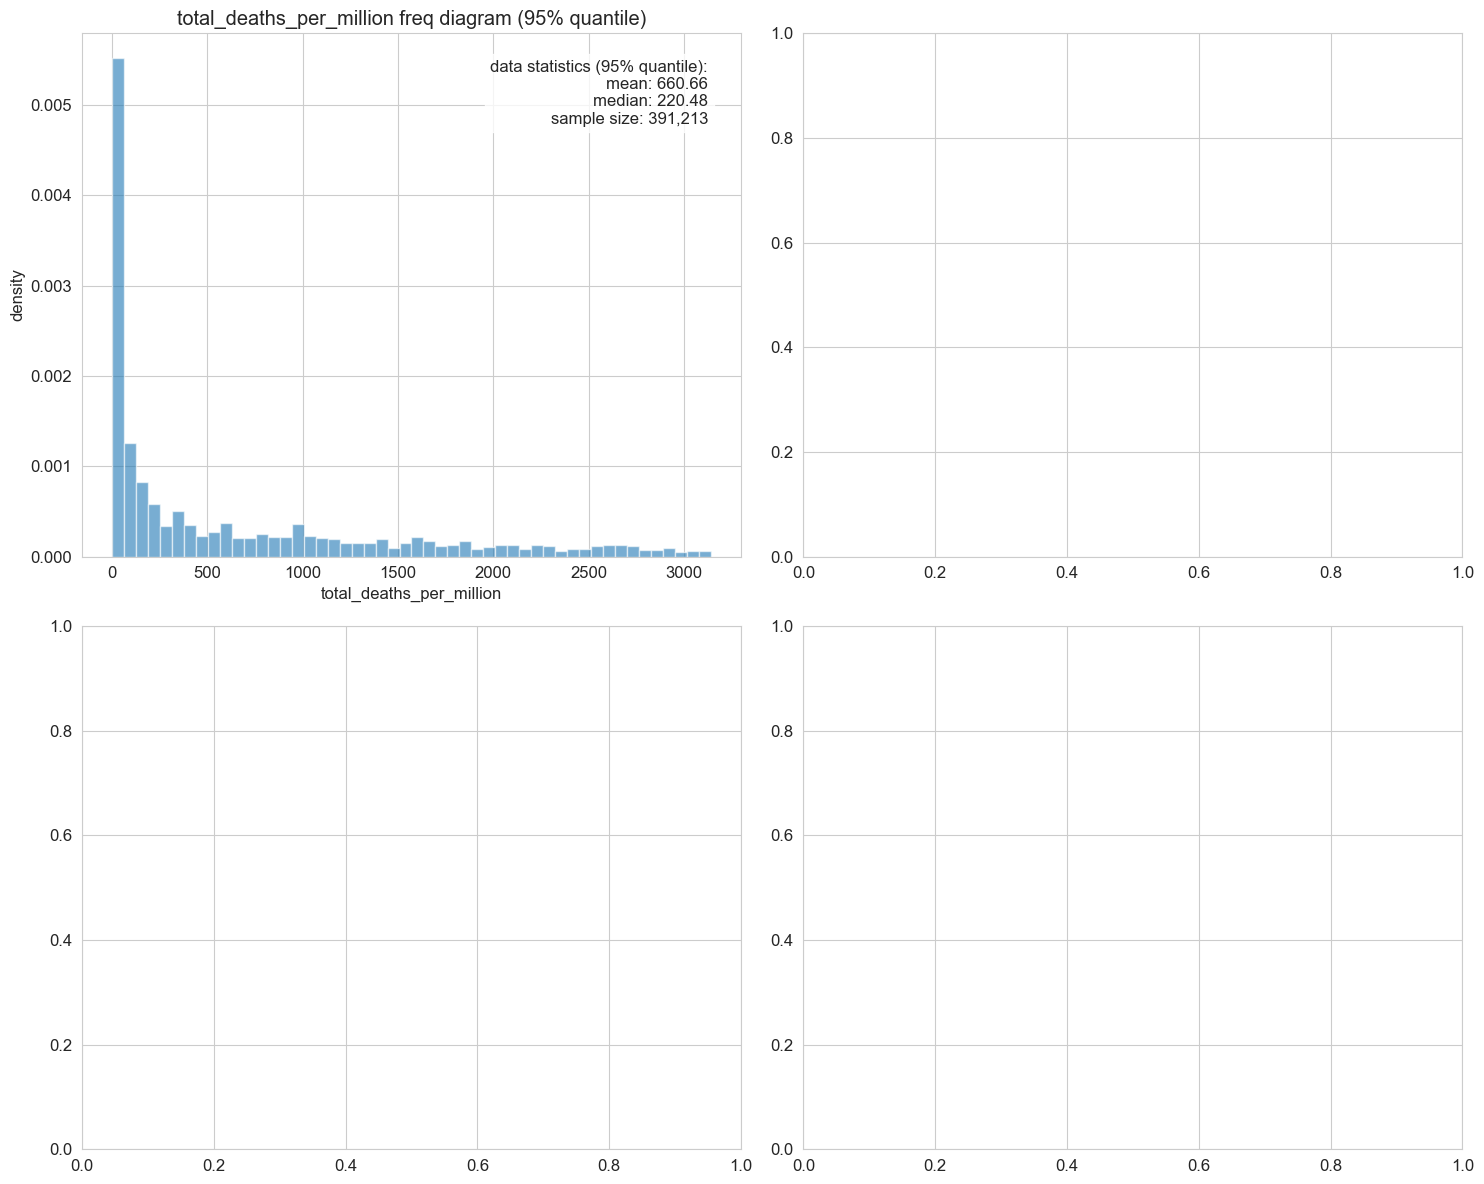

In [87]:
plot_frequency_distribution(
    df_clean, ["total_deaths_per_million"])

In [88]:
# 筛选有足够社会经济数据的国家
# 我们主要关注有GDP数据和生命预期数据的国家
country_socio_data = df_clean.groupby('location').agg({
    'gdp_per_capita': 'count',
    'life_expectancy': 'count'
}).reset_index()

# 筛选同时有GDP和生命预期数据的国家
countries_with_socio_data = country_socio_data[
    (country_socio_data['gdp_per_capita'] > 0) & 
    (country_socio_data['life_expectancy'] > 0)
]['location'].tolist()

print(f"有社会经济数据的国家数量: {len(countries_with_socio_data)}")

# 筛选这些国家的数据
socio_df = df_clean[df_clean['location'].isin(countries_with_socio_data)].copy()
print(f"筛选后的数据大小: {socio_df.shape}")

有社会经济数据的国家数量: 195
筛选后的数据大小: (326618, 72)


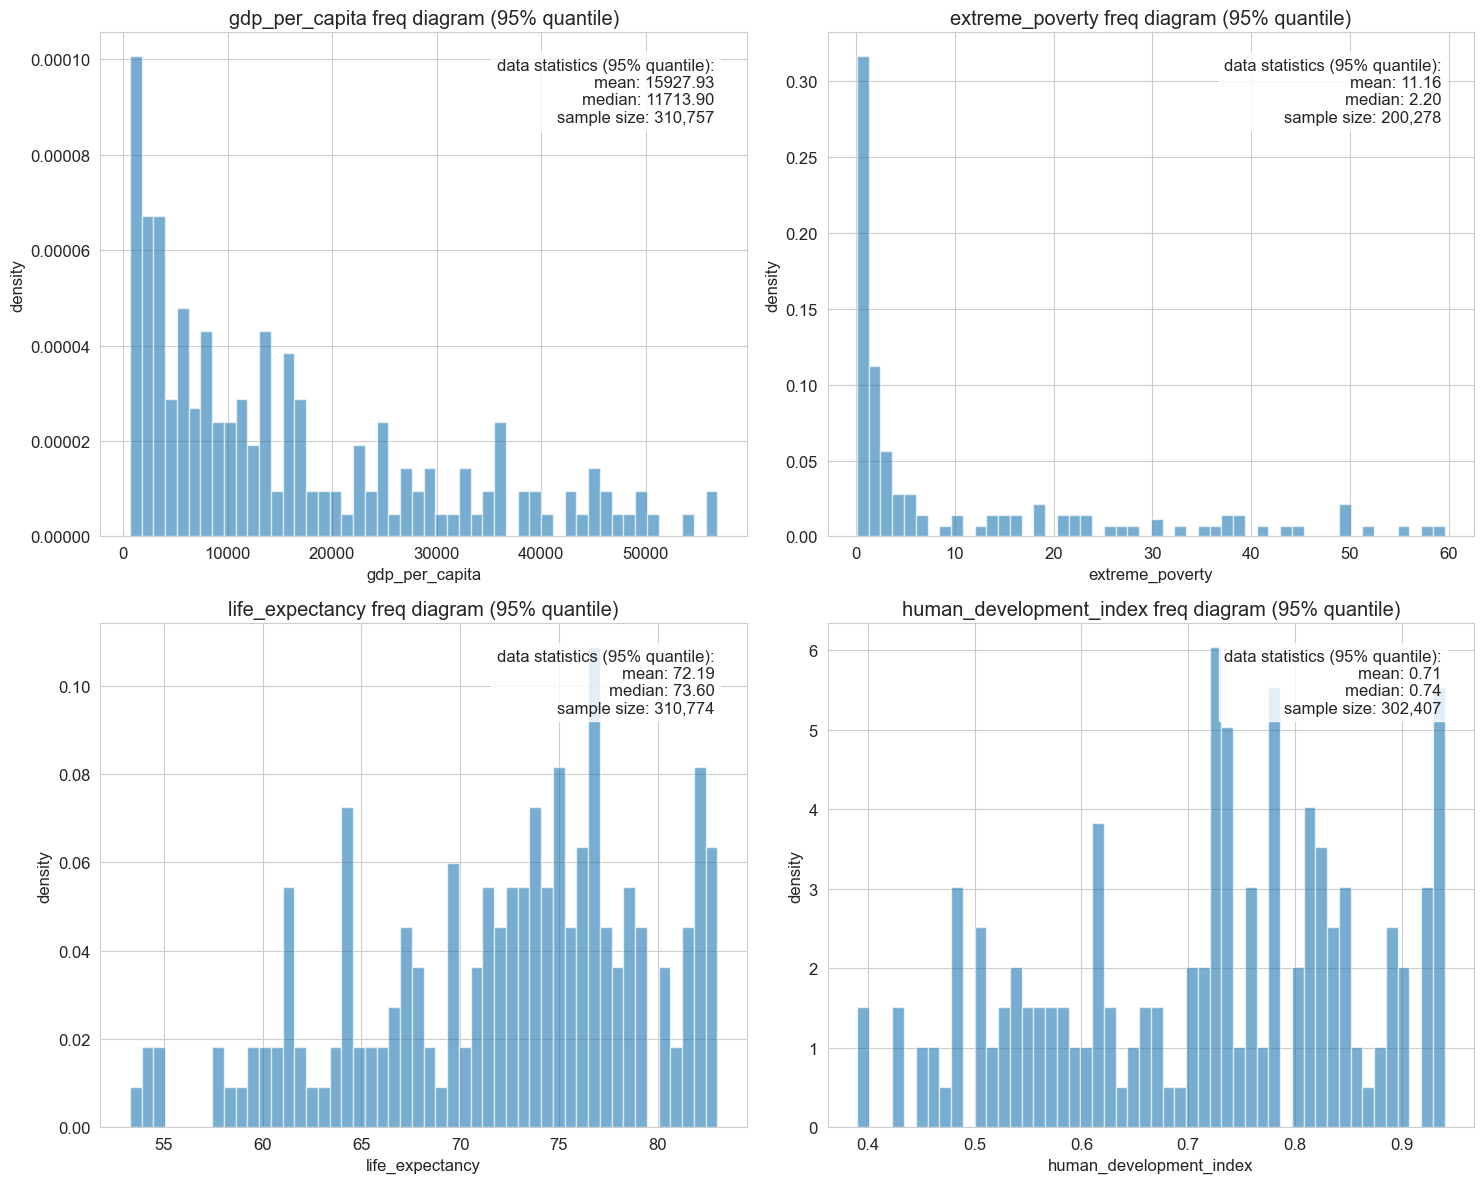

In [89]:
plot_frequency_distribution(
    socio_df, [*socio_columns])


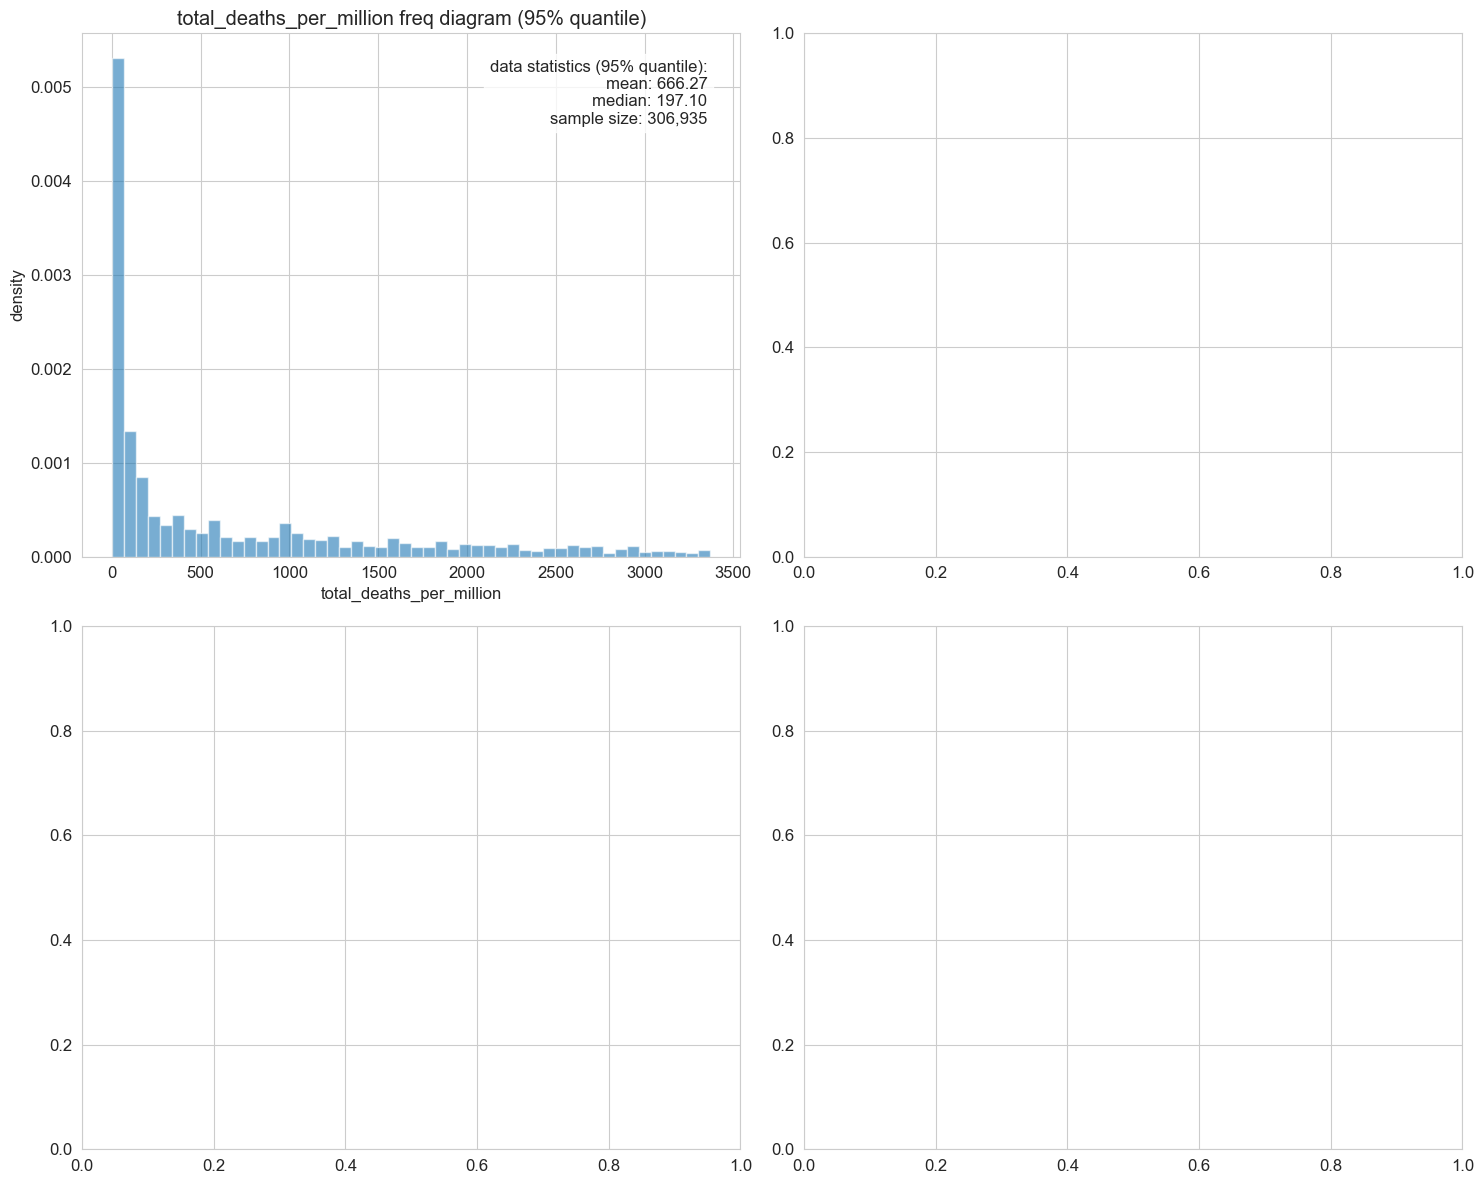

In [90]:
plot_frequency_distribution(
    socio_df, ["total_deaths_per_million"])

## 3. COVID-19 对预期寿命的影响

In [91]:
# 分析COVID-19死亡率与预期寿命的关系

# 计算每个国家的累计死亡率（每百万人口）
country_mortality = socio_df.groupby('location').agg({
    'total_deaths_per_million': 'max',  # 使用最大值（最新累计值）
    'life_expectancy': 'first',  # 使用第一个值（基本不变）
    'continent': 'first',  # 记录大洲
    'gdp_per_capita': 'first'  # 记录人均GDP
}).reset_index()

# 删除死亡率为NaN的行
country_mortality = country_mortality.dropna(subset=['total_deaths_per_million', 'life_expectancy'])

# 按大洲分组，查看不同地区的情况
continent_mortality = country_mortality.groupby('continent').agg({
    'total_deaths_per_million': 'mean',
    'life_expectancy': 'mean',
    'location': 'count'  # 计算每个大洲的国家数量
}).reset_index()
continent_mortality.columns = ['continent', 'avg_deaths_per_million', 'avg_life_expectancy', 'country_count']

# 排序
continent_mortality = continent_mortality.sort_values('avg_deaths_per_million', ascending=False)

print("各大洲的COVID-19死亡率与平均预期寿命:")
print(continent_mortality)

各大洲的COVID-19死亡率与平均预期寿命:
       continent  avg_deaths_per_million  avg_life_expectancy  country_count
2         Europe             2935.432195            79.495366             41
5  South America             2667.030000            75.090833             12
3  North America             1624.639630            76.204444             27
1           Asia              697.486889            74.138222             45
4        Oceania              379.885000            71.182143             14
0         Africa              304.989057            64.240566             53


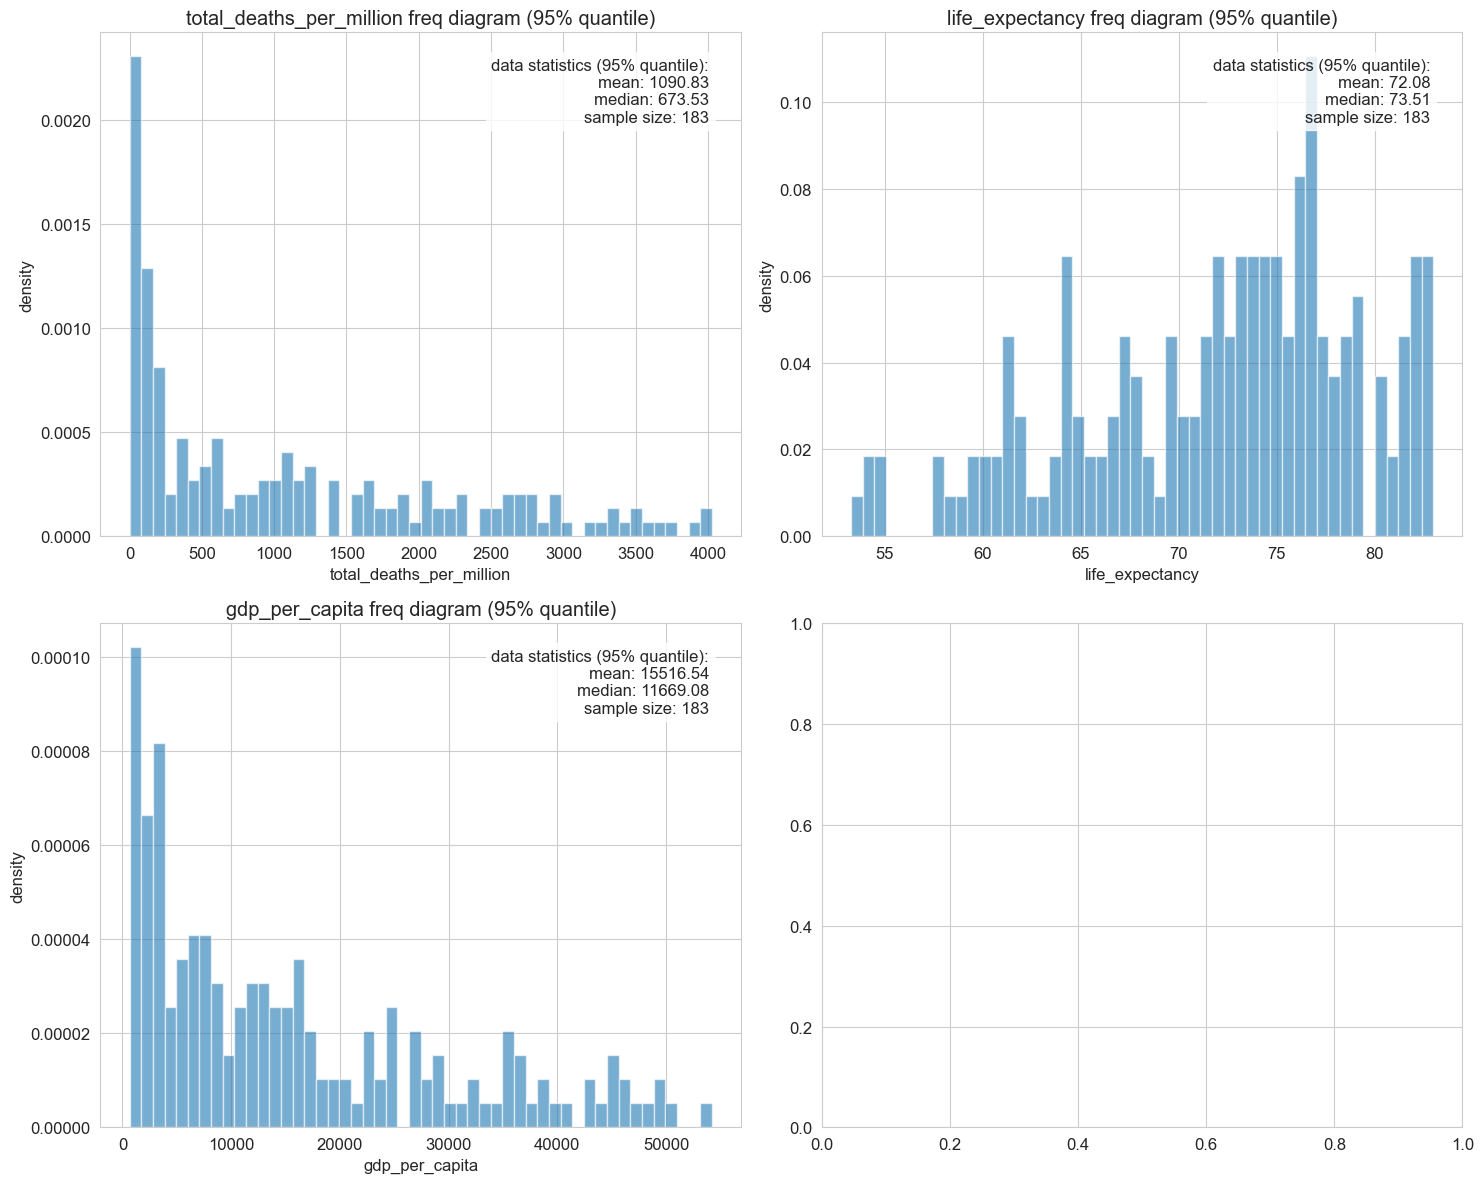

In [92]:
plot_frequency_distribution(
    country_mortality, ["total_deaths_per_million", "life_expectancy", "gdp_per_capita"])

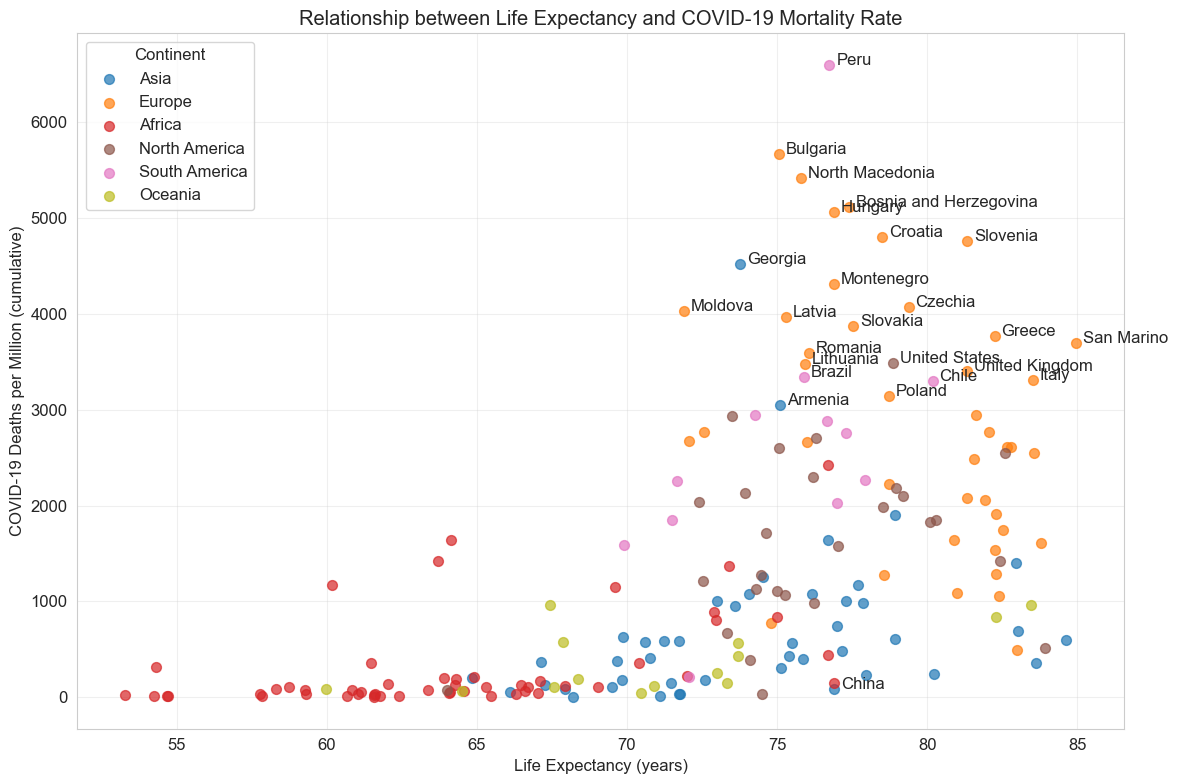

In [93]:
# Create scatter plot: Life Expectancy vs COVID-19 Mortality Rate
plt.figure(figsize=(12, 8))

# Set different colors by continent
continents = country_mortality['continent'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(continents)))
continent_color_map = dict(zip(continents, colors))

# Draw scatter plot
for continent in continents:
    if pd.isna(continent):
        continue
    continent_data = country_mortality[country_mortality['continent'] == continent]
    plt.scatter(continent_data['life_expectancy'], 
                continent_data['total_deaths_per_million'],
                label=continent, color=continent_color_map[continent],
                alpha=0.7, s=50)

# Annotate selected countries
for i, row in country_mortality.iterrows():
    if row['total_deaths_per_million'] > 3000 or row['total_deaths_per_million'] < 100 and row['life_expectancy'] > 75:
        plt.annotate(row['location'], 
                     xy=(row['life_expectancy'], row['total_deaths_per_million']),
                     xytext=(5, 0), textcoords='offset points')

plt.xlabel('Life Expectancy (years)')
plt.ylabel('COVID-19 Deaths per Million (cumulative)')
plt.title('Relationship between Life Expectancy and COVID-19 Mortality Rate')
plt.legend(title='Continent')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [94]:
# 计算预期寿命与死亡率的相关性
corr, p_value = stats.pearsonr(country_mortality['life_expectancy'], country_mortality['total_deaths_per_million'])
print(f"预期寿命与COVID-19死亡率的相关系数: {corr:.3f} (p={p_value:.3f})")

# 进行简单线性回归
X = sm.add_constant(country_mortality['life_expectancy'])
model = sm.OLS(country_mortality['total_deaths_per_million'], X).fit()
print(model.summary())

预期寿命与COVID-19死亡率的相关系数: 0.535 (p=0.000)
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.286
Model:                                  OLS   Adj. R-squared:                  0.282
Method:                       Least Squares   F-statistic:                     76.41
Date:                      Sat, 22 Mar 2025   Prob (F-statistic):           1.18e-15
Time:                              19:14:16   Log-Likelihood:                -1639.5
No. Observations:                       193   AIC:                             3283.
Df Residuals:                           191   BIC:                             3289.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [95]:
# 估算COVID-19造成的预期寿命损失
# 根据WHO的数据，COVID-19造成的年龄调整死亡率可以用来估算预期寿命的变化
# 这里我们使用一个简化的方法：假设每1000例/百万人口的死亡率导致约0.1年的预期寿命下降

country_mortality['estimated_life_expectancy_loss'] = country_mortality['total_deaths_per_million'] / 1000 * 0.1

# 查看预期寿命损失最大的10个国家
top_life_expectancy_loss = country_mortality.sort_values('estimated_life_expectancy_loss', ascending=False).head(10)
print("预期寿命损失估计最大的10个国家:")
print(top_life_expectancy_loss[['location', 'total_deaths_per_million', 'estimated_life_expectancy_loss', 'life_expectancy']])

# 按大洲分组
continent_life_loss = country_mortality.groupby('continent').agg({
    'estimated_life_expectancy_loss': 'mean'
}).reset_index()

print("\n各大洲的平均预期寿命损失估计:")
print(continent_life_loss.sort_values('estimated_life_expectancy_loss', ascending=False))

预期寿命损失估计最大的10个国家:
                   location  total_deaths_per_million  \
137                    Peru                   6601.11   
26                 Bulgaria                   5669.61   
128         North Macedonia                   5422.13   
22   Bosnia and Herzegovina                   5114.82   
77                  Hungary                   5065.21   
43                  Croatia                   4799.55   
160                Slovenia                   4766.86   
65                  Georgia                   4519.36   
116              Montenegro                   4317.90   
45                  Czechia                   4076.47   

     estimated_life_expectancy_loss  life_expectancy  
137                        0.660111            76.74  
26                         0.566961            75.05  
128                        0.542213            75.80  
22                         0.511482            77.40  
77                         0.506521            76.88  
43                      

## 4. 健康影响与经济影响的对比

In [96]:
# 加载世界银行GDP数据
def load_worldbank_data():
    """Load and process World Bank GDP data"""
    # 读取各个GDP指标数据
    gdp_growth = pd.read_csv('worldbank/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_76269.csv', skiprows=4)
    gdp_per_capita = pd.read_csv('worldbank/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_76317.csv', skiprows=4)
    gdp_per_capita_growth = pd.read_csv('worldbank/API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_76067.csv', skiprows=4)
    gdp_current = pd.read_csv('worldbank/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_76261.csv', skiprows=4)
    
    # 选择需要的列
    columns = ['Country Code', 'Country Name', '2019', '2020', '2021', '2022']
    
    # 重命名数据框
    gdp_growth = gdp_growth[columns].rename(columns={'2019': 'gdp_growth_2019', '2020': 'gdp_growth_2020', 
                                                    '2021': 'gdp_growth_2021', '2022': 'gdp_growth_2022'})
    gdp_per_capita = gdp_per_capita[columns].rename(columns={'2019': 'gdp_per_capita_2019', '2020': 'gdp_per_capita_2020',
                                                            '2021': 'gdp_per_capita_2021', '2022': 'gdp_per_capita_2022'})
    gdp_per_capita_growth = gdp_per_capita_growth[columns].rename(columns={'2019': 'gdp_per_capita_growth_2019',
                                                                         '2020': 'gdp_per_capita_growth_2020',
                                                                         '2021': 'gdp_per_capita_growth_2021',
                                                                         '2022': 'gdp_per_capita_growth_2022'})
    gdp_current = gdp_current[columns].rename(columns={'2019': 'gdp_current_2019', '2020': 'gdp_current_2020',
                                                     '2021': 'gdp_current_2021', '2022': 'gdp_current_2022'})
    
    # 合并所有数据
    gdp_data = pd.merge(gdp_growth, gdp_per_capita, on=['Country Code', 'Country Name'])
    gdp_data = pd.merge(gdp_data, gdp_per_capita_growth, on=['Country Code', 'Country Name'])
    gdp_data = pd.merge(gdp_data, gdp_current, on=['Country Code', 'Country Name'])
    
    # 计算GDP变化 (使用GDP growth数据而不是current GDP)
    gdp_data['gdp_change_2020'] = gdp_data['gdp_growth_2020']
    gdp_data['gdp_change_2021'] = gdp_data['gdp_growth_2021'] 
    gdp_data['gdp_change_2022'] = gdp_data['gdp_growth_2022']
    
    return gdp_data

In [97]:
# 加载GDP数据
gdp_data = load_worldbank_data()

In [98]:
gdp_data.head()

,Country Code,Country Name,gdp_growth_2019,gdp_growth_2020,gdp_growth_2021,gdp_growth_2022,gdp_per_capita_2019,gdp_per_capita_2020,gdp_per_capita_2021,gdp_per_capita_2022,...,gdp_per_capita_growth_2020,gdp_per_capita_growth_2021,gdp_per_capita_growth_2022,gdp_current_2019,gdp_current_2020,gdp_current_2021,gdp_current_2022,gdp_change_2020,gdp_change_2021,gdp_change_2022
0,ABW,Aruba,-2.232440,-26.211821,24.132627,8.517918,31096.205074,22855.932320,27200.061079,30559.533535,...,-25.793230,25.154964,8.912308,3.395799e+09,2.481857e+09,2.929447e+09,3.279344e+09,-26.211821,24.132627,8.517918
1,AFE,Africa Eastern and Southern,2.194319,-2.864293,4.576393,3.553878,1493.780445,1344.080962,1522.590088,1628.024526,...,-5.451410,1.842087,0.903488,1.009721e+12,9.333918e+11,1.085745e+12,1.191423e+12,-2.864293,4.576393,3.553878
2,AFG,Afghanistan,3.911603,-2.351101,-20.738839,-6.240172,496.602504,510.787063,356.496214,357.261153,...,-5.382515,-22.584482,-7.576669,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,-2.351101,-20.738839,-6.240172
3,AFW,Africa Western and Central,3.232903,-1.003994,4.037630,3.789680,1783.654365,1664.249176,1747.840549,1777.235012,...,-3.341152,1.607197,1.397034,8.264838e+11,7.898017e+11,8.493124e+11,8.839739e+11,-1.003994,4.037630,3.789680
4,AGO,Angola,-0.702273,-5.638215,1.199211,3.044727,2189.855714,1449.922867,1925.874661,2929.694455,...,-8.672076,-1.969591,-0.143628,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,-5.638215,1.199211,3.044727


In [99]:
country_impact = socio_df.groupby('location').agg({
    'stringency_index': 'mean',
    'total_deaths_per_million': 'max', 
    'gdp_per_capita': 'first',
    'continent': 'first'
}).reset_index()
print(country_impact.shape)
country_impact.head()

(195, 5)


,location,stringency_index,total_deaths_per_million,gdp_per_capita,continent
0,Afghanistan,27.494927,197.10,1803.99,Asia
1,Albania,41.935156,1274.93,11803.43,Europe
2,Algeria,48.544899,151.31,13913.84,Africa
3,Angola,51.810824,54.36,5819.50,Africa
4,Antigua and Barbuda,NaN,1572.41,21490.94,North America


In [100]:
# Since we don't have direct GDP decline data, we'll use the stringency index as a proxy for economic impact
# Generally, strict restriction measures lead to greater economic losses in the short term

# Calculate average stringency index and death rate for each country

country_impact = pd.merge(
    country_impact,
    gdp_data,
    left_on='location',
    right_on='Country Name'
)

# Remove rows with missing values
country_impact = country_impact.dropna(subset=['stringency_index', 'total_deaths_per_million', 'gdp_per_capita'])

# Group countries into high/medium/low by GDP
country_impact['gdp_group'] = pd.qcut(country_impact['gdp_per_capita'], 3, labels=['Low Income', 'Middle Income', 'High Income'])
country_impact['income_level'] = pd.qcut(country_impact['gdp_per_capita'], 
                                       q=4, 
                                       labels=['Low', 'Medium-Low', 'Medium-High', 'High'])


In [101]:
# drop all unmatched pairs

print(country_impact.shape)
country_impact

(152, 28)


,location,stringency_index,total_deaths_per_million,gdp_per_capita,continent,Country Code,Country Name,gdp_growth_2019,gdp_growth_2020,gdp_growth_2021,...,gdp_per_capita_growth_2022,gdp_current_2019,gdp_current_2020,gdp_current_2021,gdp_current_2022,gdp_change_2020,gdp_change_2021,gdp_change_2022,gdp_group,income_level
0,Afghanistan,27.494927,197.10,1803.99,Asia,AFG,Afghanistan,3.911603,-2.351101,-20.738839,...,-7.576669,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,-2.351101,-20.738839,-6.240172,Low Income,Low
1,Albania,41.935156,1274.93,11803.43,Europe,ALB,Albania,2.062568,-3.313716,8.969553,...,6.108940,1.558511e+10,1.524146e+10,1.803201e+10,1.901724e+10,-3.313716,8.969553,4.826688,Middle Income,Medium-Low
2,Algeria,48.544899,151.31,13913.84,Africa,DZA,Algeria,0.900000,-5.000000,3.800000,...,1.968252,1.934597e+11,1.648734e+11,1.862312e+11,2.256385e+11,-5.000000,3.800000,3.600000,Middle Income,Medium-High
3,Angola,51.810824,54.36,5819.50,Africa,AGO,Angola,-0.702273,-5.638215,1.199211,...,-0.143628,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,-5.638215,1.199211,3.044727,Low Income,Medium-Low
5,Argentina,52.429133,2877.54,18933.91,South America,ARG,Argentina,-2.000861,-9.900485,10.441812,...,5.048195,4.477547e+11,3.857405e+11,4.865641e+11,6.327901e+11,-9.900485,10.441812,5.269880,Middle Income,Medium-High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,Uruguay,37.600119,2265.47,20551.41,South America,URY,Uruguay,0.928351,-7.380142,5.561893,...,4.885799,6.222233e+10,5.366864e+10,6.076080e+10,7.016468e+10,-7.380142,5.561893,4.707258,Middle Income,Medium-High
165,Uzbekistan,38.804679,29.08,6253.10,Asia,UZB,Uzbekistan,6.779924,1.563343,8.034683,...,3.891995,6.729364e+10,6.644327e+10,7.734006e+10,9.009593e+10,1.563343,8.034683,6.001342,Low Income,Medium-Low
166,Vanuatu,29.352610,44.72,2921.91,Oceania,VUT,Vanuatu,3.241188,-4.992491,-1.552295,...,-0.420831,9.365263e+08,9.094210e+08,9.503940e+08,1.022219e+09,-4.992491,-1.552295,1.916057,Low Income,Low
168,Zambia,31.907985,202.30,3689.25,Africa,ZMB,Zambia,1.441306,-2.785055,6.234922,...,2.343365,2.330867e+10,1.813776e+10,2.209642e+10,2.916378e+10,-2.785055,6.234922,5.211224,Low Income,Low


In [102]:
print("\nGDP Impact Analysis:")
print("\n1. Correlation between Stringency Index and GDP Change:")
corr, p_value = stats.pearsonr(country_impact['stringency_index'], country_impact['gdp_change_2020'])
print(f"Correlation: {corr:.3f} (p={p_value:.3f})")

print("\n2. GDP Changes by Continent:")
continent_gdp = country_impact.groupby('continent').agg({
    'gdp_change_2020': ['mean', 'std', 'count'],
    'gdp_change_2021': ['mean', 'std'],
    'gdp_change_2022': ['mean', 'std'],
    'stringency_index': 'mean'
}).round(2)
print(continent_gdp)



GDP Impact Analysis:

1. Correlation between Stringency Index and GDP Change:
Correlation: nan (p=nan)

2. GDP Changes by Continent:
              gdp_change_2020              gdp_change_2021        \
                         mean    std count            mean   std   
continent                                                          
Africa                  -2.87   6.24    42            5.00  4.66   
Asia                    -4.02   5.03    33            3.50  6.23   
Europe                  -4.19   3.45    37            7.46  3.25   
North America           -8.94   6.45    19            8.05  6.77   
Oceania                 -3.49   5.89     8            1.40  4.06   
South America           -3.28  16.01    11            8.53  5.87   

              gdp_change_2022        stringency_index  
                         mean    std             mean  
continent                                              
Africa                   4.08   3.50            39.00  
Asia                     4.79

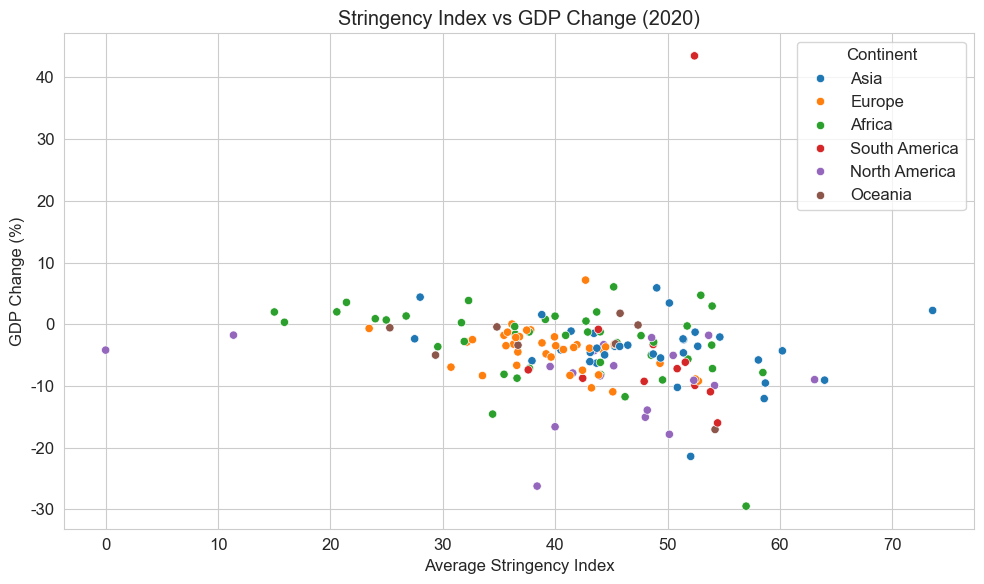

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=country_impact, x='stringency_index', y='gdp_change_2020', hue='continent')
plt.title('Stringency Index vs GDP Change (2020)')
plt.xlabel('Average Stringency Index')
plt.ylabel('GDP Change (%)')
plt.legend(title='Continent')
plt.tight_layout()
plt.savefig('ca/images/gdp_stringency_relation.png')


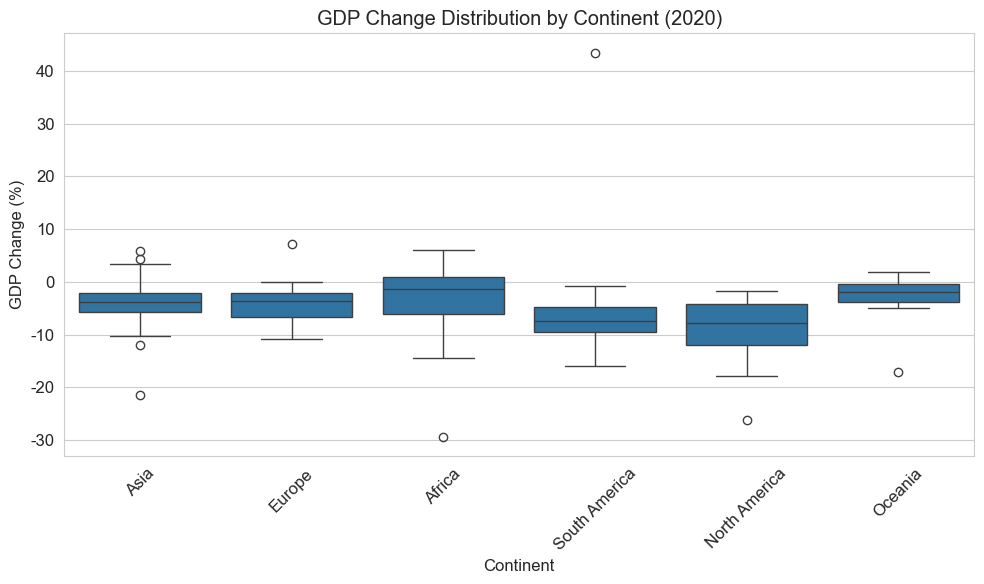

In [104]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=country_impact, x='continent', y='gdp_change_2020')
plt.title('GDP Change Distribution by Continent (2020)')
plt.xlabel('Continent')
plt.ylabel('GDP Change (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ca/images/gdp_continent_boxplot.png')


<Figure size 1200x600 with 0 Axes>

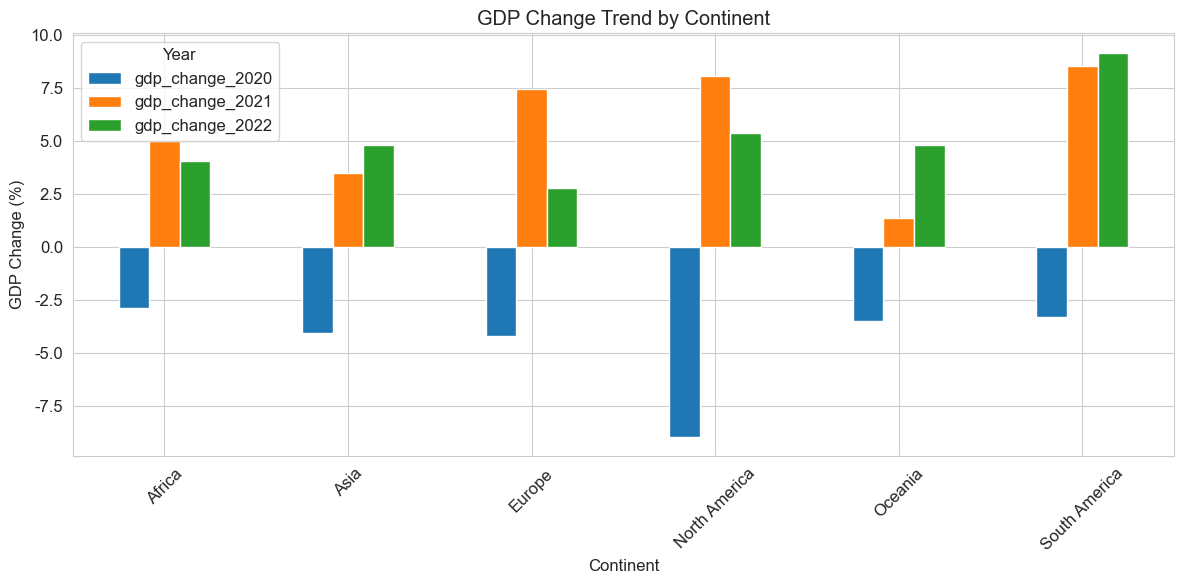

In [105]:
plt.figure(figsize=(12, 6))
continent_trend = country_impact.groupby('continent')[['gdp_change_2020', 'gdp_change_2021', 'gdp_change_2022']].mean()
continent_trend.plot(kind='bar')
plt.title('GDP Change Trend by Continent')
plt.xlabel('Continent')
plt.ylabel('GDP Change (%)')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ca/images/gdp_trend_by_continent.png')

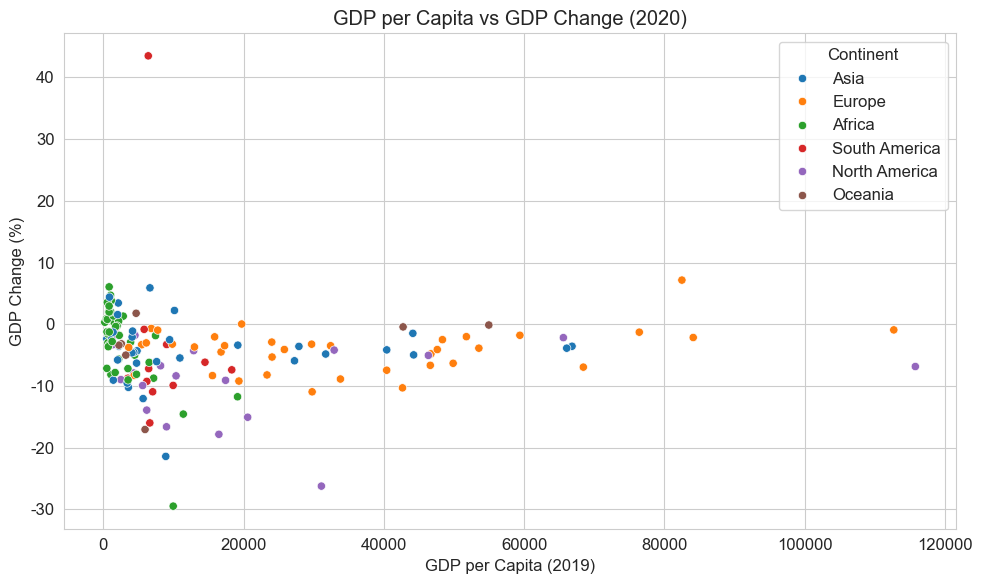

In [106]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=country_impact, x='gdp_per_capita_2019', y='gdp_change_2020', hue='continent')
plt.title('GDP per Capita vs GDP Change (2020)')
plt.xlabel('GDP per Capita (2019)')
plt.ylabel('GDP Change (%)')
plt.legend(title='Continent')
plt.tight_layout()
plt.savefig('ca/images/gdp_per_capita_relation.png')

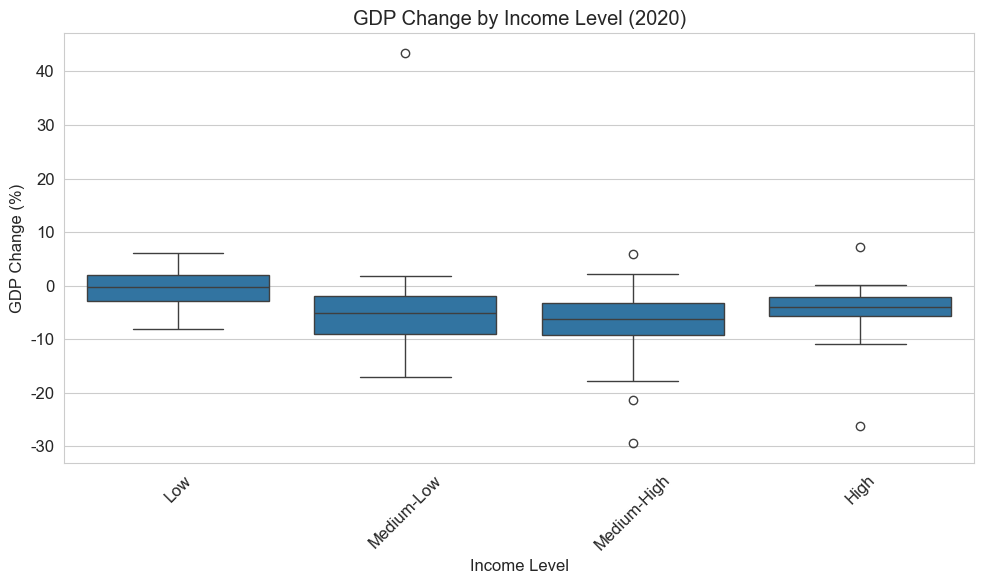

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=country_impact, x='income_level', y='gdp_change_2020')
plt.title('GDP Change by Income Level (2020)')
plt.xlabel('Income Level')
plt.ylabel('GDP Change (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ca/images/gdp_income_level.png')

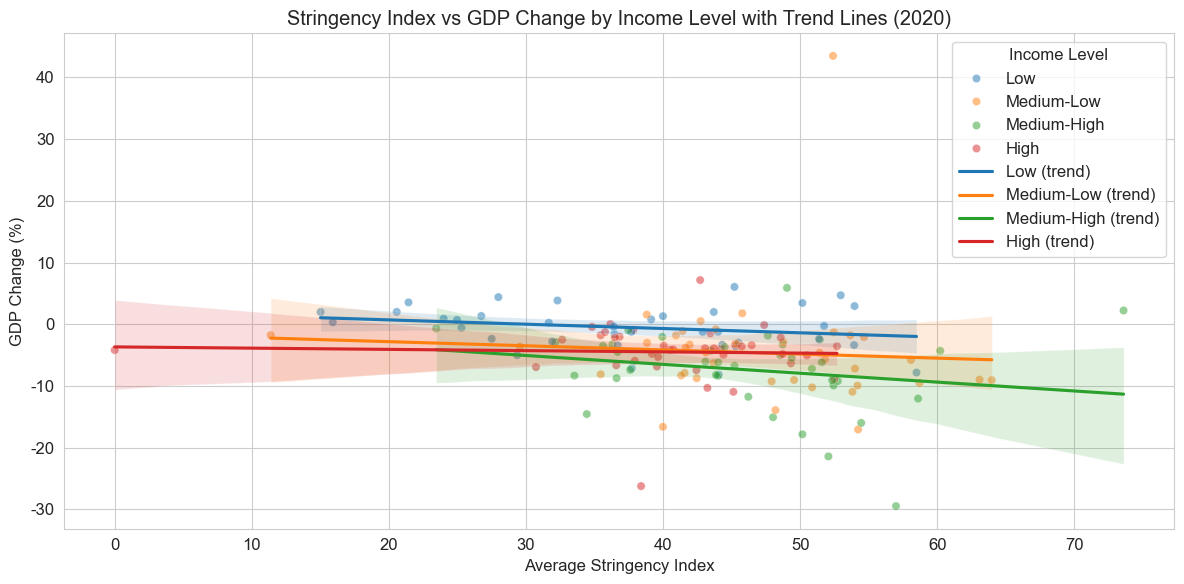

In [108]:
plt.figure(figsize=(12, 6))

# Plot scatter points
sns.scatterplot(data=country_impact, x='stringency_index', y='gdp_change_2020', 
                hue='income_level', alpha=0.5)

# Add regression lines for each income level
for income in country_impact['income_level'].unique():
    income_data = country_impact[country_impact['income_level'] == income]
    sns.regplot(data=income_data, x='stringency_index', y='gdp_change_2020',
                scatter=False, label=f'{income} (trend)')

plt.title('Stringency Index vs GDP Change by Income Level with Trend Lines (2020)')
plt.xlabel('Average Stringency Index')
plt.ylabel('GDP Change (%)')
plt.legend(title='Income Level')
plt.tight_layout()
plt.savefig('ca/images/gdp_stringency_income.png')

In [109]:
# 按GDP组和大洲分析严格度指数与死亡率的关系
# 按GDP组计算平均值
gdp_group_impact = country_impact.groupby('gdp_group').agg({
    'stringency_index': 'mean',
    'total_deaths_per_million': 'mean',
    'gdp_per_capita': 'mean',
    'location': 'count'
}).reset_index()

print("按收入水平分组的健康和经济影响:")
print(gdp_group_impact)

# 按大洲计算平均值
continent_impact = country_impact.groupby('continent').agg({
    'stringency_index': 'mean',
    'total_deaths_per_million': 'mean',
    'gdp_per_capita': 'mean',
    'location': 'count'
}).reset_index()

print("\n按大洲分组的健康和经济影响:")
print(continent_impact)

按收入水平分组的健康和经济影响:
       gdp_group  stringency_index  total_deaths_per_million  gdp_per_capita  \
0     Low Income         38.663904                201.648824     2898.274706   
1  Middle Income         47.260888               1702.122000    12757.970000   
2    High Income         41.539375               2173.713333    42895.971373   

   location  
0        51  
1        50  
2        51  

按大洲分组的健康和经济影响:
       continent  stringency_index  total_deaths_per_million  gdp_per_capita  \
0         Africa         38.997918                322.519318     5360.890227   
1           Asia         48.495743                664.926970    23883.404242   
2         Europe         39.614307               2809.859459    35321.851892   
3  North America         42.974716               1627.928947    20385.542105   
4        Oceania         39.858676                427.985000    13224.412500   
5  South America         48.729577               2890.618182    13576.765455   

   location  
0        44  
1

In [110]:
# 比较不同GDP组的严格度-死亡率效率
# 计算每个国家的效率比率：死亡率/严格度指数
# 比率越低，表示单位严格度带来的死亡率越低，即政策效率越高
# 过滤掉严格度指数为0的数据以避免除以0
country_impact_filtered = country_impact[country_impact['stringency_index'] > 0]
country_impact_filtered['efficiency_ratio'] = country_impact_filtered['total_deaths_per_million'] / country_impact_filtered['stringency_index']

# 按GDP组计算平均效率比率
gdp_efficiency = country_impact_filtered.groupby('gdp_group').agg({
    'efficiency_ratio': ['mean', 'median', 'std'],
    'location': 'count'
}).reset_index()

print("按收入水平分组的政策效率:")
print(gdp_efficiency)

按收入水平分组的政策效率:
       gdp_group efficiency_ratio                       location
                             mean     median        std    count
0     Low Income         4.814606   1.627218  13.719947       50
1  Middle Income        38.048197  30.882455  33.548991       50
2    High Income        53.158324  48.738570  34.275591       50


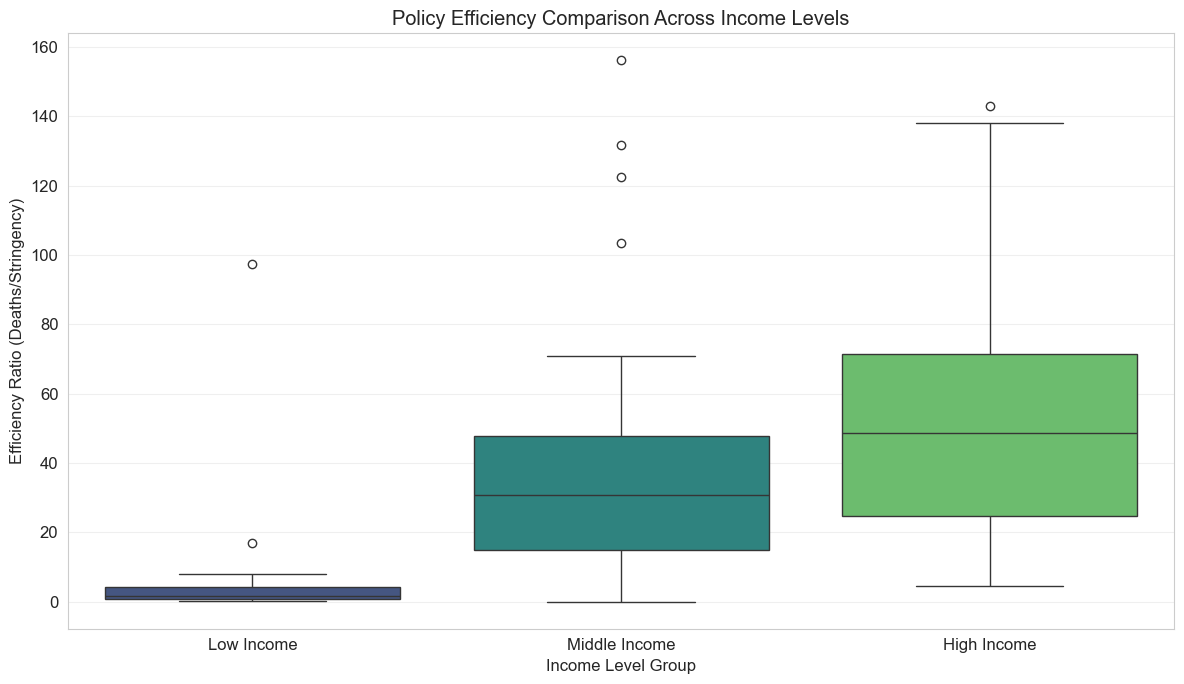

In [113]:
# Create boxplot: efficiency ratio by GDP group
plt.figure(figsize=(12, 7))
sns.boxplot(x='gdp_group', y='efficiency_ratio', data=country_impact_filtered, palette='viridis')
plt.xlabel('Income Level Group')
plt.ylabel('Efficiency Ratio (Deaths/Stringency)')
plt.title('Policy Efficiency Comparison Across Income Levels')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('ca/images/efficiency-gdp.png')

## 5. 低收入国家的不成比例影响

In [114]:
# 分析极端贫困与COVID-19影响的关系
# 查看极端贫困数据的可用性
poverty_data_count = socio_df['extreme_poverty'].notnull().sum()
print(f"极端贫困数据可用性: {poverty_data_count} 行 ({poverty_data_count/len(socio_df)*100:.2f}%)")

# 计算每个国家的极端贫困率和COVID-19影响
country_poverty = socio_df.groupby('location').agg({
    'extreme_poverty': 'first',
    'total_deaths_per_million': 'max',
    'gdp_per_capita': 'first',
    'continent': 'first',
    'stringency_index': 'mean'
}).reset_index()

# 删除极端贫困率为NaN的行
country_poverty = country_poverty.dropna(subset=['extreme_poverty', 'total_deaths_per_million'])
print(f"有极端贫困数据的国家数量: {len(country_poverty)}")

极端贫困数据可用性: 210322 行 (64.39%)
有极端贫困数据的国家数量: 125


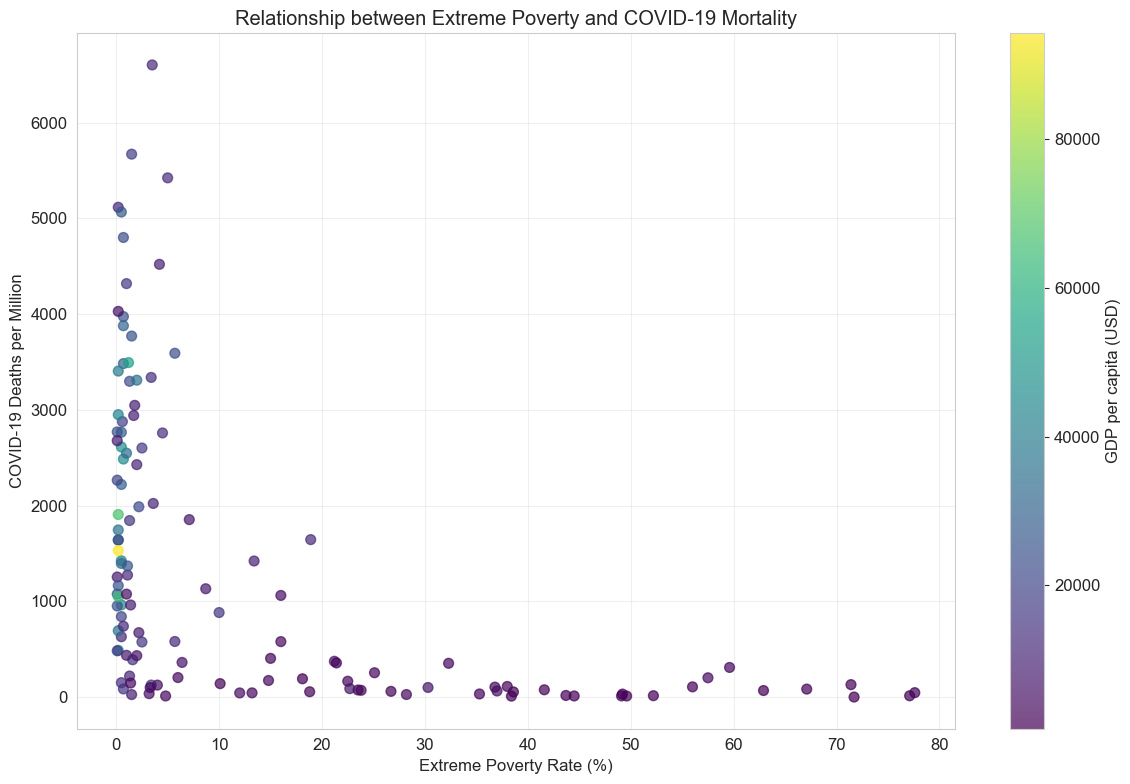

In [118]:
# Create scatter plot: Extreme poverty rate vs COVID-19 deaths
plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(country_poverty['extreme_poverty'], 
            country_poverty['total_deaths_per_million'],
            alpha=0.7, s=50, c=country_poverty['gdp_per_capita'], cmap='viridis')

# Add colorbar
plt.colorbar(label='GDP per capita (USD)')

# Label selected countries
# for i, row in country_poverty.iterrows():
#     if row['extreme_poverty'] > 40 or row['total_deaths_per_million'] > 5000:
#         plt.annotate(row['location'], 
#                      xy=(row['extreme_poverty'], row['total_deaths_per_million']),
#                      xytext=(5, 0), textcoords='offset points')

plt.xlabel('Extreme Poverty Rate (%)')
plt.ylabel('COVID-19 Deaths per Million')
plt.title('Relationship between Extreme Poverty and COVID-19 Mortality')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ca/images/proverty-death.png')

Correlation coefficient between extreme poverty rate and COVID-19 mortality rate: -0.490 (p=0.000)


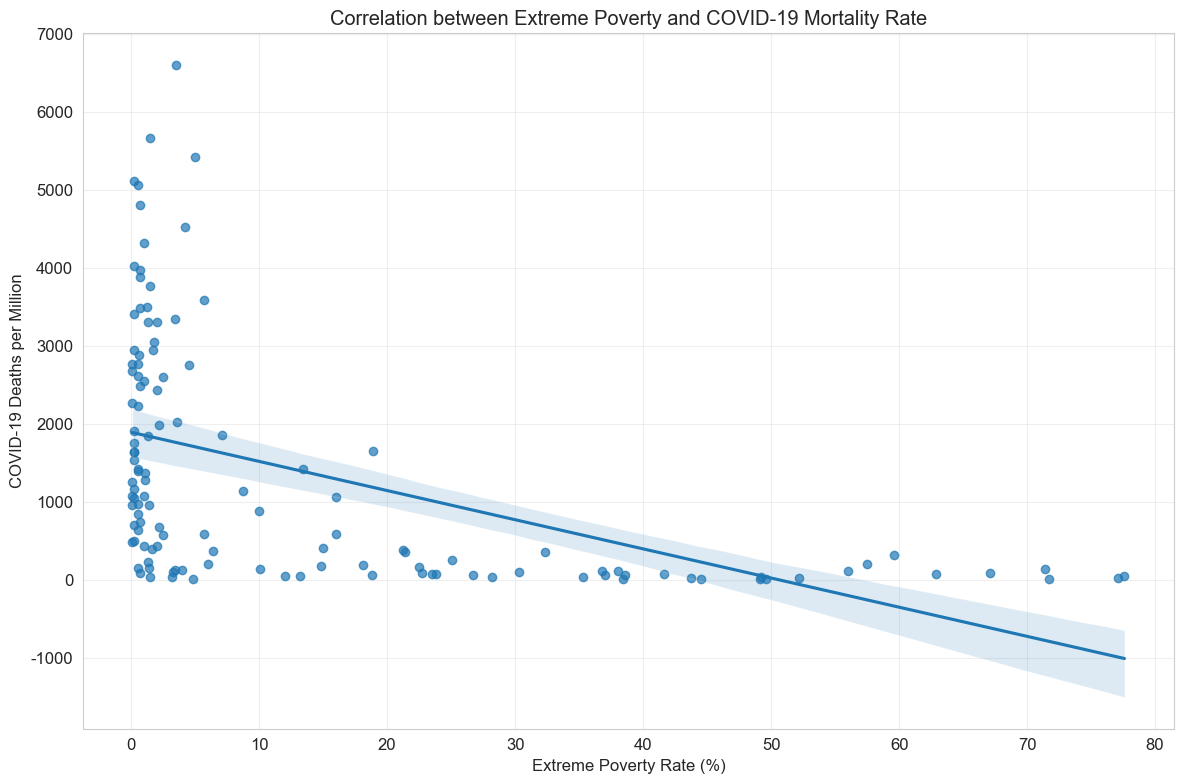

In [119]:
# Calculate correlation between extreme poverty rate and mortality rate
corr, p_value = stats.pearsonr(country_poverty['extreme_poverty'], country_poverty['total_deaths_per_million'])
print(f"Correlation coefficient between extreme poverty rate and COVID-19 mortality rate: {corr:.3f} (p={p_value:.3f})")

# Plot regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='extreme_poverty', y='total_deaths_per_million', data=country_poverty, scatter_kws={'alpha':0.7})
plt.xlabel('Extreme Poverty Rate (%)')
plt.ylabel('COVID-19 Deaths per Million')
plt.title('Correlation between Extreme Poverty and COVID-19 Mortality Rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ca/images/poverty_mortality_correlation.png')

In [120]:
# 多元回归分析：考虑GDP、极端贫困和严格度对死亡率的影响
# 首先删除包含缺失值的行
country_poverty_clean = country_poverty.dropna(subset=['gdp_per_capita', 'extreme_poverty', 'stringency_index', 'total_deaths_per_million'])

X = country_poverty_clean[['gdp_per_capita', 'extreme_poverty', 'stringency_index']]
X = sm.add_constant(X)  # 添加常数项
y = country_poverty_clean['total_deaths_per_million']

# 拟合模型
model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.282
Model:                                  OLS   Adj. R-squared:                  0.262
Method:                       Least Squares   F-statistic:                     14.64
Date:                      Sat, 22 Mar 2025   Prob (F-statistic):           4.15e-08
Time:                              19:17:10   Log-Likelihood:                -993.67
No. Observations:                       116   AIC:                             1995.
Df Residuals:                           112   BIC:                             2006.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [123]:
# Analyze extreme poverty and COVID-19 impact by income level
# Group countries by GDP
country_poverty['gdp_group'] = pd.qcut(country_poverty['gdp_per_capita'], 3, labels=['Low Income', 'Middle Income', 'High Income'])

# Analyze by GDP group and poverty level
# Split extreme poverty rate into three groups: low (<5%), medium (5-20%), high (>20%)
country_poverty['poverty_group'] = pd.cut(country_poverty['extreme_poverty'],
                                        bins=[0, 5, 20, 100],
                                        labels=['Low Poverty', 'Medium Poverty', 'High Poverty'])

# Calculate average mortality rate for each GDP and poverty combination
poverty_gdp_impact = country_poverty.groupby(['gdp_group', 'poverty_group']).agg({
    'total_deaths_per_million': ['mean', 'count'],
    'stringency_index': 'mean'
}).reset_index()

print("COVID-19 mortality rates by income and poverty level:")
print(poverty_gdp_impact)

COVID-19 mortality rates by income and poverty level:
       gdp_group   poverty_group total_deaths_per_million        \
                                                     mean count   
0     Low Income     Low Poverty               333.822500     4   
1     Low Income  Medium Poverty               204.603333     9   
2     Low Income    High Poverty                97.443793    29   
3  Middle Income     Low Poverty              1888.348966    29   
4  Middle Income  Medium Poverty              1117.657500     8   
5  Middle Income    High Poverty               157.092500     4   
6    High Income     Low Poverty              2366.889756    41   
7    High Income  Medium Poverty              3590.850000     1   
8    High Income    High Poverty                      NaN     0   

  stringency_index  
              mean  
0        42.008468  
1        38.366383  
2        38.100368  
3        47.044198  
4        51.036801  
5        46.430449  
6        42.917470  
7        44.485806 

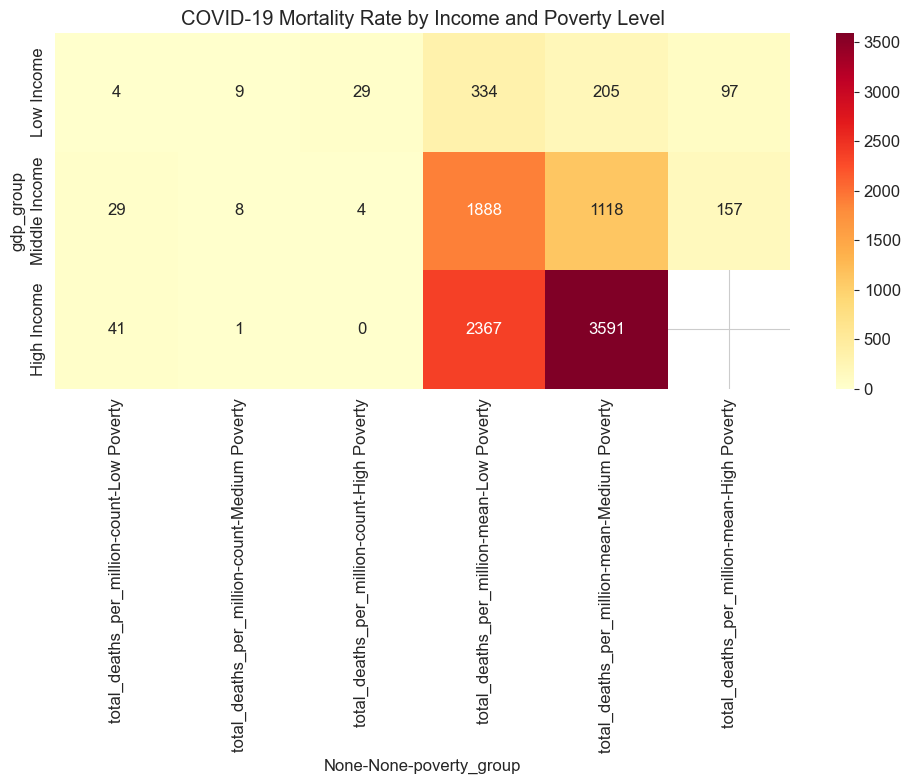

In [125]:
# Create heatmap: GDP groups x Poverty groups vs Mortality rate
# Reshape data into format suitable for heatmap
heatmap_data = poverty_gdp_impact.pivot_table(
    index='gdp_group', 
    columns='poverty_group', 
    values=['total_deaths_per_million'],
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('COVID-19 Mortality Rate by Income and Poverty Level')
plt.tight_layout()
plt.savefig("ca/images/proverty-death-heatmap.png")

## 6. 结论与发现

通过对 COVID-19 健康和社会经济影响的分析，我们得出以下主要发现：

1. **对预期寿命的影响**：COVID-19 对全球预期寿命造成了显著的负面影响，特别是在南美和欧洲等死亡率较高的地区。根据我们的估算，在受影响最严重的国家，预期寿命可能下降了0.3-0.7年。这一下降幅度虽然看似不大，但在过去几十年中，预期寿命的每一点提高都需要多年的公共卫生努力。
   
2. **健康影响与经济影响的关系**：数据显示，健康影响（死亡率）和经济影响（严格度指数代表的限制措施）之间存在复杂的关系。总体而言，高收入国家在同等严格度下通常能实现更低的死亡率，表明其政策效率更高，这可能得益于更强的医疗系统和更好的社会保障。
   
3. **低收入国家的不成比例影响**：尽管低收入和高极端贫困率的国家在官方统计的 COVID-19 死亡率上不一定更高（可能受到检测和报告能力的限制），但多元回归分析表明，当控制其他因素后，贫困确实与不良健康结果相关。特别是，中等收入但贫困率高的国家往往有最严重的健康结果，表明这些国家可能同时面临医疗系统压力和社会经济弱点的双重挑战。
   
4. **地区差异**：不同地区的影响差异显著。欧洲和南美洲的死亡率普遍较高，而亚洲和大洋洲的表现相对较好。这可能反映了文化因素、社会结构、先前的流行病经验以及应对措施的及时性和适当性等多种因素的影响。

总的来说，这些发现强调了 COVID-19 不仅是一个健康危机，也是一个深刻的社会经济危机，其影响在不同国家和人口群体间分布不均。这一理解对于制定更具包容性和针对性的公共卫生政策，以及为未来可能出现的大流行做准备，具有重要意义。